# Cross Entropy


In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

(x_train_arr, y_train_arr), (x_test_arr, y_test_arr) = mnist.load_data()
x_train, x_test, y_train, y_test = tf.convert_to_tensor(x_train_arr), tf.convert_to_tensor(x_test_arr), tf.convert_to_tensor(y_train_arr), tf.convert_to_tensor(y_test_arr)


2024-11-27 07:54:14.050200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732722854.062438  351476 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732722854.066392  351476 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 07:54:14.078983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1732722855.431366  351476 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 65

It's time for us to start our journey into prediction. We're going to start with a very basic model 1-nn. We expect this to have perfect accuracy on the training data.

In [2]:
def unit_vectorize_input(input):
    vectors =  tf.reshape(tf.cast(input, tf.float32), [tf.shape(input)[0], -1])
    unit_vectors = tf.linalg.l2_normalize(vectors, axis=1)
    return unit_vectors

def nearest_neighbor_model(input):
    cosine_sim = tf.matmul(unit_vectorize_input(input), unit_vectorize_input(x_train), transpose_b=True)
    y_train_indices = tf.argmax(cosine_sim, axis=1)
    prediction = tf.gather(y_train, y_train_indices)
    return tf.one_hot(prediction, depth=10)

nearest_neighbor_model(x_train[:1000])

<tf.Tensor: shape=(1000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

We're going to compare this to a naive model that gives every class an equal probability.

In [3]:
import tensorflow as tf

# Define the uniform model
num_classes = 10  
uniform_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28)),  # Placeholder input, adjust as needed
    tf.keras.layers.Lambda(lambda x: tf.fill((tf.shape(x)[0], num_classes), 1.0 / num_classes))
])

As expected this outputs a prediction vector where every class has an equal probability.

## Evaluating our First Models

Now let's score both models on 100 samples. We're going to do something bad and evaluate the models on the training data. This is just to introduce some of the ideas of evaluation. Later we will evaluate them on test data instead.

In [4]:
x_sample = x_train[:100]
y_sample = y_train[:100]


pred_uniform = uniform_model(x_sample)
pred_nn = nearest_neighbor_model(x_sample)

We expect `nearest_neighbor_model` to perform much better than `uniform_model` on the training data. 

Why is this? 
- We expect the `nearest_neighbor_model` will always give the correct class a probability of `1`. 
- We expect `uniform_model` will always give the correct class a probability of `1/10`. Let's double check this assumption.

Let's verify this assumption before continuing.

We can multiply the predictions by the output vector to get a better idea of what's going on. 

In [5]:
tf.one_hot(y_sample, 10) * pred_uniform

<tf.Tensor: shape=(100, 10), dtype=float32, numpy=
array([[0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. ],
     

If we ignore the zeros, we can see that this model always outputs a .1 for the correct class. 

Instead of ignoring the zeros, let's just sum across the second index to remove them.

In [6]:
tf.reduce_sum(tf.one_hot(y_sample, 10) * pred_uniform, axis=1)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32)>

Ah ha! Just as we predicted the uniform class always outputs a `1/10` probability for the correct class. 

Let's now test our same assumption with `nearest_neighbor_model`


In [7]:
tf.reduce_sum(tf.one_hot(y_sample, 10) * pred_nn, axis=1)

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>

We see that the nearest neighbor model gives the correct class a higher probability than the uniform and so on the training data it performs better. 

Let's make this finding a bit more concise.



In [8]:
mean_prob_for_uniform = tf.reduce_mean(tf.reduce_sum(tf.one_hot(y_sample, 10) * pred_uniform, axis=1))
mean_prob_for_nn = tf.reduce_mean(tf.reduce_sum(tf.one_hot(y_sample, 10) * pred_nn, axis=1))

print("Mean probability for uniform model: ", mean_prob_for_uniform.numpy())
print("Mean probability for nearest neighbor model: ", mean_prob_for_nn.numpy())

Mean probability for uniform model:  0.1
Mean probability for nearest neighbor model:  1.0


## Mean Probability Loss

We're going to call our fancy new model scorer **mean probability**. The better the mean probability a model assigns to a model, the better the model.. right? We're going to see that there are a few issues with this metric, but in the process we'll find a much better metric called *cross entropy*. 

### Coin Flips 

To show the pitfalls of **mean probability** we'll use it in perhaps the simplest statistical situation - an unfair coin.

Let's say we have an unfair coin that flips heads 80% of the time. Let's see if our *mean probability loss* can help us find the unfairness of the coin after observing 1000 flips.

In [9]:
# define a random tensor where there is a 70% chance of a 1 and 30% chance of a 0

sample_size =10000
random_tensor = tf.random.uniform([sample_size, ], minval=0, maxval=1)
binary_tensor = tf.cast(random_tensor > 0.2, tf.int32)
flips = tf.one_hot(binary_tensor, 2)
# sum up each row of the one hot tensor
tf.reduce_mean(flips, axis=0)



<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.2006, 0.7994], dtype=float32)>

Let's maximize *mean probability* and see what our best model for the coin's fairness is.

When I say 'model' it's a bit of a stretch. The 'model' is just a guess at the probability of heads using the data. So in this case it's just a number. 

Because we generated the data, we know that the perfect model is $P(H)=.8$. Hopefully mean probability leads us to this number.

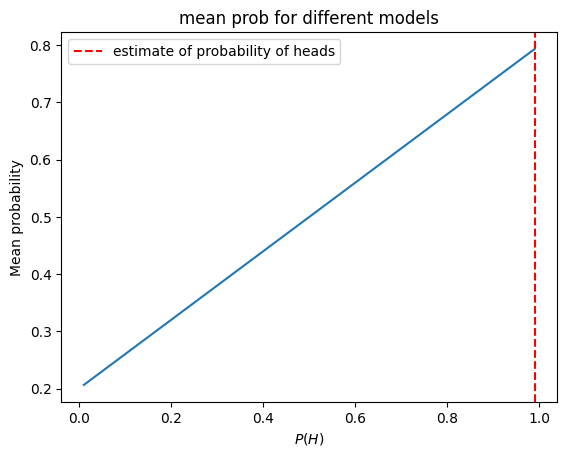

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from math import log

def get_mean_prob(x):
    predictions =  tf.constant([[(1-x), (x)]] * sample_size, dtype=tf.float32)    
    return tf.reduce_mean(tf.reduce_sum(flips * predictions, axis=1)).numpy()

x_values = np.linspace(0.01, 0.99, 100)  # Use numpy linspace for easier iteration
y_values = [get_mean_prob(float(i)) for i in x_values]
y_star = max(y_values) 
x_star = x_values[y_values.index(y_star)]
plt.plot(x_values, y_values)
plt.axvline(x=x_star, color='r', linestyle='--', label='estimate of probability of heads')
# label needs to show up
plt.legend()
plt.xlabel('$P(H)$')
plt.ylabel('Mean probability')
plt.title('mean prob for different models')

plt.show()



Something is wrong here. We are trying to use our new *mean probability* metric to infer the likelihood of a heads. We expect that the higher this metric is, the better the model. But the 'best' model according to mean probability is giving 100% likleyhood to 1, even though we *know* the best model should give 80% to 1. 

**What is going wrong**

Apparently *mean probability* prefers a confident model that always predicts heads. Let's comapre this confident model, with the model we *know is correct*.

In [11]:
from dlib.helper import printmd

predictions_correct = tf.constant([[.2, .8]] * sample_size, dtype=tf.float32)
predictions_confident = tf.constant([[0, 1]] * sample_size, dtype=tf.float32)

models = {
    "predictions_correct": predictions_correct,
    "predictions_confident": predictions_confident
}

for model in ["predictions_correct", "predictions_confident"]:
    predictions = models[model]
    dot = tf.reduce_sum(flips * predictions, axis=1)
    mean_prob = tf.reduce_mean(dot).numpy()
    printmd(f"**{model} model** \n  - Mean probability: {mean_prob:.2f} \n - probability of right answer \n {dot} \n ")



**predictions_correct model** 
  - Mean probability: 0.68 
 - probability of right answer 
 [0.8 0.8 0.8 ... 0.2 0.8 0.8] 
 

**predictions_confident model** 
  - Mean probability: 0.80 
 - probability of right answer 
 [1. 1. 1. ... 0. 1. 1.] 
 

The confident model decides to put all of it's probability on heads. It assigns 0 probability to tails. When a heads is called, it looks prophetic, when a tail gets called it gets penalized, but that doesn't happen very often. Apparently with **mean probability**, it pays to be cocky.

There is not justice here. The confident model get's all the rewards while our correct model meekly eeks by. We need justice. Which means we need to move beyond *mean probability*.

## Penalized Mean Probability

The problem is that we aren't punishing the confident model enough for unlikely events. If a model predicts a 1, we want a penalty function that looks like one of these: 




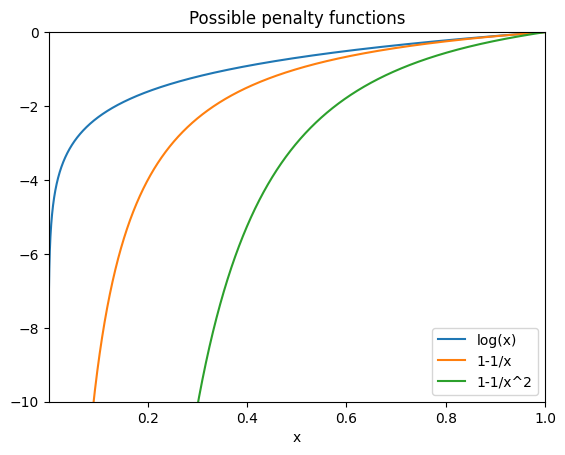

In [12]:
#Make a graph of a log, and of 1/x with matplot lib where the values range from 0 to 1 with a linspace

x_values = np.linspace(0.000001, 1, 10000)  # Use numpy linspace for easier iteration
log_values = [log(i) for i in x_values]
inverse_values = [1-1/i for i in x_values]
sq_inverse_values = [1-1/(i*i) for i in x_values]

plt.plot(x_values, log_values, label='log(x)')
plt.plot(x_values, inverse_values, label='1-1/x')
plt.plot(x_values, sq_inverse_values, label='1-1/x^2')
plt.xlabel('x')
# plt should show values from -10 to 0
plt.ylim(-10, 0)
plt.xlim(0.001, 1)
plt.legend()
plt.title('Possible penalty functions')

plt.show()


These penalty functions will have very high penalties for the 0's outputted by the confident model.

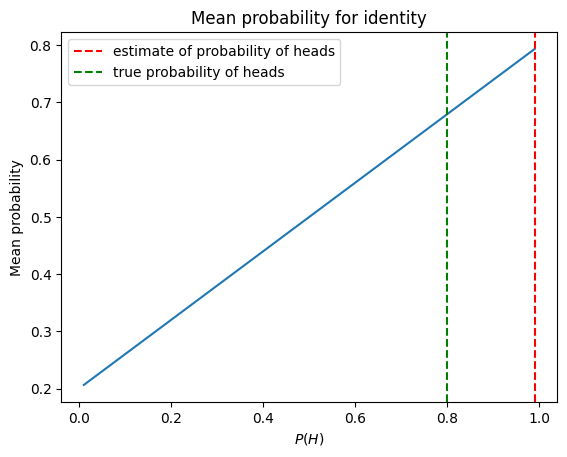

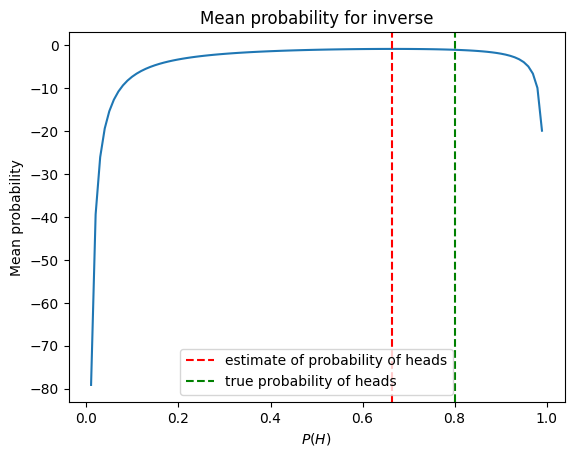

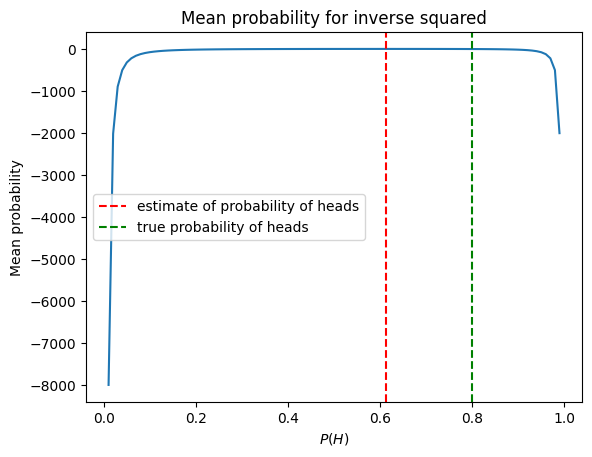

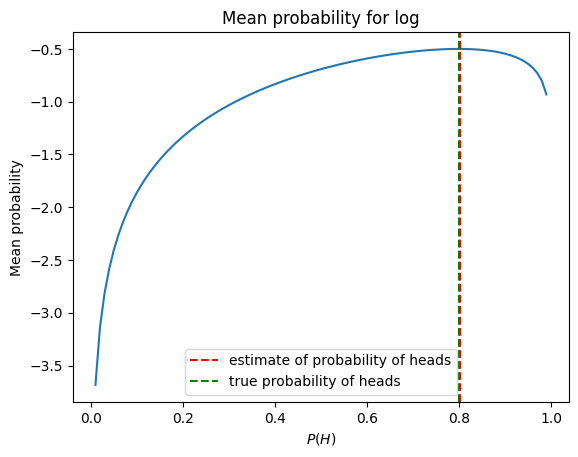

In [13]:
def find_coin_flip_probability(penalty, penalty_name):
    def get_penalized_mean_prob(x):
        predictions =  tf.constant([[(1-x), (x)]] * sample_size, dtype=tf.float32)
        
        return tf.reduce_mean(tf.reduce_sum(flips * penalty(predictions), axis=1)).numpy()

    x_values = np.linspace(0.01, 0.99, 100)  # Use numpy linspace for easier iteration
    y_values = [get_penalized_mean_prob(float(i)) for i in x_values]
    y_star = max(y_values) 
    x_star = x_values[y_values.index(y_star)]
    plt.plot(x_values, y_values)
    plt.axvline(x=x_star, color='r', linestyle='--', label='estimate of probability of heads')
    plt.axvline(x=0.8, color='g', linestyle='--', label='true probability of heads')
    # label needs to show up
    plt.legend()
    plt.xlabel('$P(H)$')
    plt.ylabel('Mean probability')
    plt.title(f'Mean probability for {penalty_name}')

    plt.show()

penalties = [
    (lambda x: x, "identity"),
    (lambda x: 1-1/x, "inverse"),
    (lambda x: 1-1/(x*x), "inverse squared"),
    (tf.math.log, "log"),
]

for penalty, penalty_name in penalties:
    find_coin_flip_probability(penalty, penalty_name)

Wow, there is something very special about modifying our **mean probability** using logs! It puts all the other penalty functions to shame. 

We're going to answer the *mystery of the log*, but first we need to look again at our mean error function. It turns out that there is on other way to modify it to punish low likelihood events. In my opinion it's even more elegant.


## Geoemtric Mean Probability


**Idea: Modify mean probability to be geometric mean probability**

We just discussed how *mean probability* doesn't do a good job of punishing bad predations. We just solved the issue by adding a penalty function. 

Anther interesting way to punsish bad predictions is be replacing the arthimatic mean of probablities with the *geometric mean*


### Arithmetic Mean
The arithmetic mean of a set of values $ x_1, x_2, \ldots, x_n $ is defined as:

$$
\text{Arithmetic Mean} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

### Geometric Mean
The geometric mean of a set of values $ x_1, x_2, \ldots, x_n $ is defined as:

$$
\text{Geometric Mean} = \left( \prod_{i=1}^{n} x_i \right)^{\frac{1}{n}}
$$

In theory this should also punish low probabilities. let's try it out



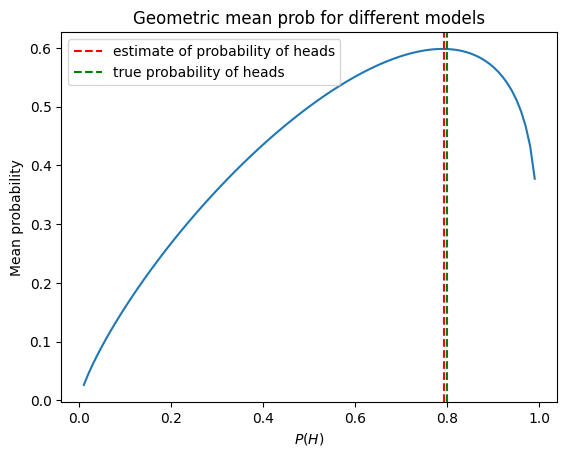

In [14]:
import numpy as np
import matplotlib.pyplot as plt
# Dummy one_hot_tensor for demonstration purposes; replace with your actual tensor

def get_geometric_mean_prob(x):
    first_n = 100
    precision = tf.float64
    predictions =  tf.constant([[(1-x), (x)]] * first_n, dtype=precision)
    # the geometric mean goes to 0 too quickly so we're cheating and only calculating the first 30 values
    probs = tf.reduce_sum(tf.cast( flips[:first_n], dtype=precision) * predictions, axis=1)
    prod = tf.reduce_prod(probs).numpy()
    nth_root = prod**(1/first_n)
    return nth_root



x_values = np.linspace(0.01, 0.99, 100)  # Use numpy linspace for easier iteration
y_values = [get_geometric_mean_prob(float(i)) for i in x_values]
y_star = max(y_values) 
x_star = x_values[y_values.index(y_star)]
plt.plot(x_values, y_values)
plt.axvline(x=x_star, color='r', linestyle='--', label='estimate of probability of heads')
plt.axvline(x=0.8, color='g', linestyle='--', label='true probability of heads')
# label needs to show up
plt.legend()
plt.xlabel('$P(H)$')
plt.ylabel('Mean probability')
plt.title('Geometric mean prob for different models')

plt.show()


Wow! That works perfectly! But now we have two ways to modify the *mean probability* to be better
1. **geometric mean probability** Replace the arithmetic mean with a geometric mean
2. **penalized mean probability** Use logs as a penalty function

How are we to choose between these two methods of evaluation models? 

We like that *peanlized mean probability* is more numerically stable, but are there situations where **geometric mean probability** is better?

No! The reason is that the *penalized mean probability* is just the $log$ of the *geometric mean probability*. Therefore maximizing one is equivalent to maximizing the other. 

Here's some empirical proof.




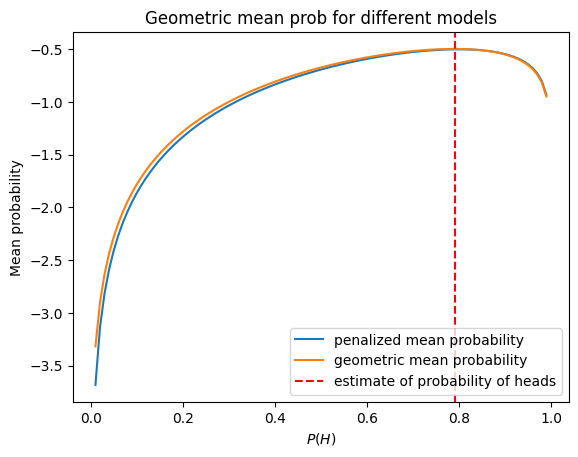

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from math import log
# Dummy one_hot_tensor for demonstration purposes; replace with your actual tensor



def get_penalized_mean_prob(x):
    predictions =  tf.constant([[(1-x), (x)]] * sample_size, dtype=tf.float32)
    
    return tf.reduce_mean(tf.reduce_sum(flips * penalty(predictions), axis=1)).numpy()

x_values = np.linspace(0.01, 0.99, 100)  # Use numpy linspace for easier iteration
y_values_pen = [get_penalized_mean_prob(float(i)) for i in x_values]
y_values_geo = [log(get_geometric_mean_prob(float(i)) + .01) for i in x_values]
plt.plot(x_values, y_values_pen, label='penalized mean probability')
plt.plot(x_values, y_values_geo, label='geometric mean probability')
plt.axvline(x=x_star, color='r', linestyle='--', label='estimate of probability of heads')
# label needs to show up
plt.legend()
plt.xlabel('$P(H)$')
plt.ylabel('Mean probability')
plt.title('Geometric mean prob for different models')

plt.show()


## Maximum Likelihood

We've learned that the penalized mean probability is just the log of the geometric mean probability. The mystery still remains, why is the geometric mean probability so effective?

The reason has to do with probability theory. 

Let's go back to our coin example. Say we observe the following:

`HHTH` How likely is this particular sequence. According to the correct model, the likelihood is `.8*.8*.2*.8` while confident model things this is impossible. Anyways, since you use multiplication in probability to determine the likleyhood of a sequence, the geometric mean probability is just the nth root of the likelihood. So when we maximize the *geometric mean probability* we are choosing the model that finds the data to be the most likely. This concept is called *maximum likelihood*, and is core to all of statistics. 



## In Summary 

The geometric mean is the nth root of the likelihood that a model assigns to an sequence of events. Maximizing the geometric mean probability is the same as maximizing the likelihood. The geometric mean probability is numerically unstable and so we use the log of it instead, which we've been calling the penalized mean probability. In the field this is called *Cross Entropy*. 

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='softmax')
])

/home/jackson/code/dl/venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
scce = tf.keras.losses.SparseCategoricalCrossentropy()

pred_train = model(x_train)

loss = scce(y_train, pred_train)

print(loss)

tf.Tensor(152.22583, shape=(), dtype=float32)


I'm a little surprised the sparse entropy loss is so high. I would expect it to be around 2.3 like the uniform model.

Let's calculate this ourselves to see what's going on.


In [18]:
# cross_entropy = -tf.reduce_sum(tf.one_hot(y_train, depth=10) * tf.math.log(pred_train + 1e-30), axis=1)  # Avoid log(0) with small epsilon

 
tf.math.log(pred_train) * tf.one_hot(y_train, depth=10)

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[ nan,  nan,  -0., ...,  nan,  -0.,  nan],
       [-inf,  -0.,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  -0.,  nan],
       ...,
       [ -0.,  nan,   0., ...,  nan,  nan,  nan],
       [ -0.,  nan,  -0., ...,  nan,  nan,  nan],
       [ nan,   0.,  -0., ...,  nan, -inf,  nan]], dtype=float32)>

In [19]:
from math import log, log10

-log(1/10)

2.3025850929940455

In [20]:
with tf.GradientTape() as tape:
    pred_train = model(x_train)

    loss = scce(y_train, pred_train)

gradients = tape.gradient(loss, model.trainable_variables)


Reshaped gradient shape: (28, 28, 10)


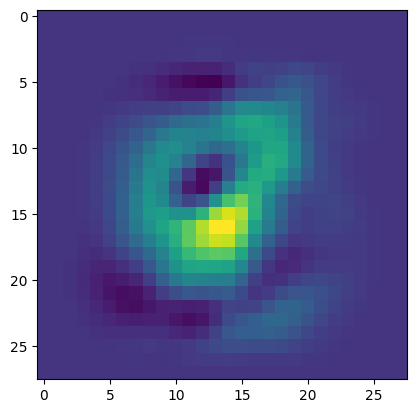

In [21]:
# let's look at gradients



from matplotlib import pyplot as plt

reshaped_gradient = tf.reshape(gradients[0], (28, 28, 10))
print("Reshaped gradient shape:", reshaped_gradient.shape)

plt.imshow(reshaped_gradient[:,:, 3])